<a href="https://colab.research.google.com/github/amacharla15/CSCI611_Akshith_Macharla/blob/main/build_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks - Build Model
---
In this notebook, we build and train a **CNN** to classify images from the CIFAR-10 database.
* The code provided here are **almost** working. You are required to build up a CNN model and train it.
* Make sure you covered implementations of the **TODO**s in this notebook

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='cifar_data.png' width=50% height=50% />

### Optional: Use [CUDA](http://pytorch.org/docs/stable/cuda.html) if Available

Since these are color (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, but they utilize GPU's for effcient parallel computation.

In [4]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)
---
Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [6]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch

num_workers = 0
batch_size = 64
valid_size = 0.2

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_data_aug = datasets.CIFAR10('data', train=True, download=True, transform=train_transform)
train_data_plain = datasets.CIFAR10('data', train=True, download=True, transform=test_transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=test_transform)

num_train = len(train_data_aug)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    train_data_aug,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers
)

valid_loader = torch.utils.data.DataLoader(
    train_data_plain,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    num_workers=num_workers
)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:05<00:00, 31.2MB/s]


### Visualize a Batch of Training Data

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

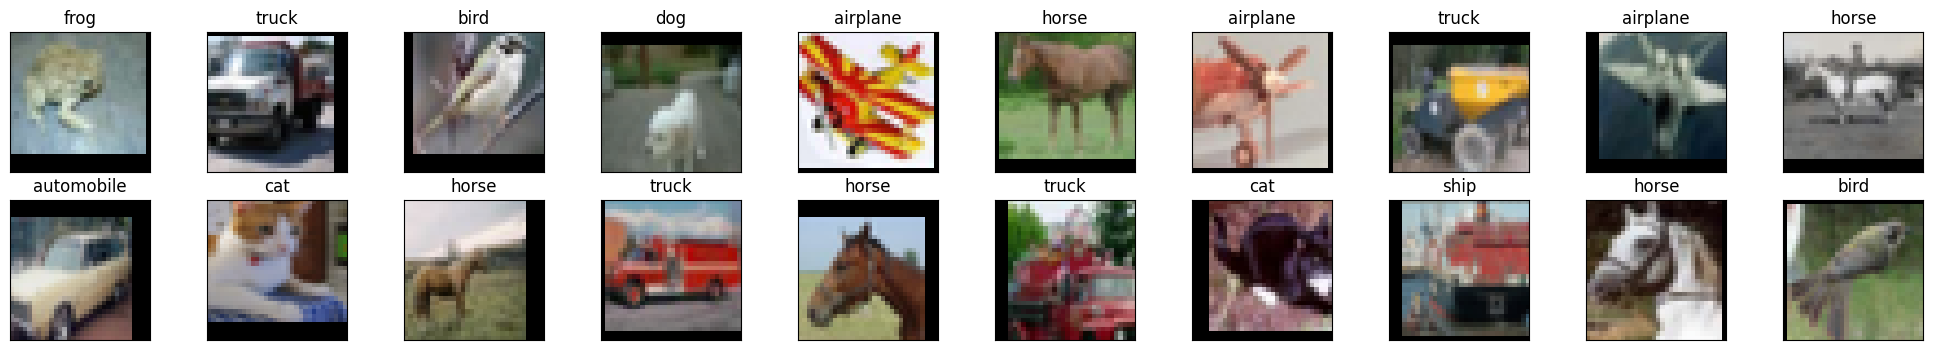

In [8]:
# obtain one batch of training images
dataiter = iter(train_loader)
#images, labels = dataiter.next() #python, torchvision version match issue
images, labels = next(dataiter)


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

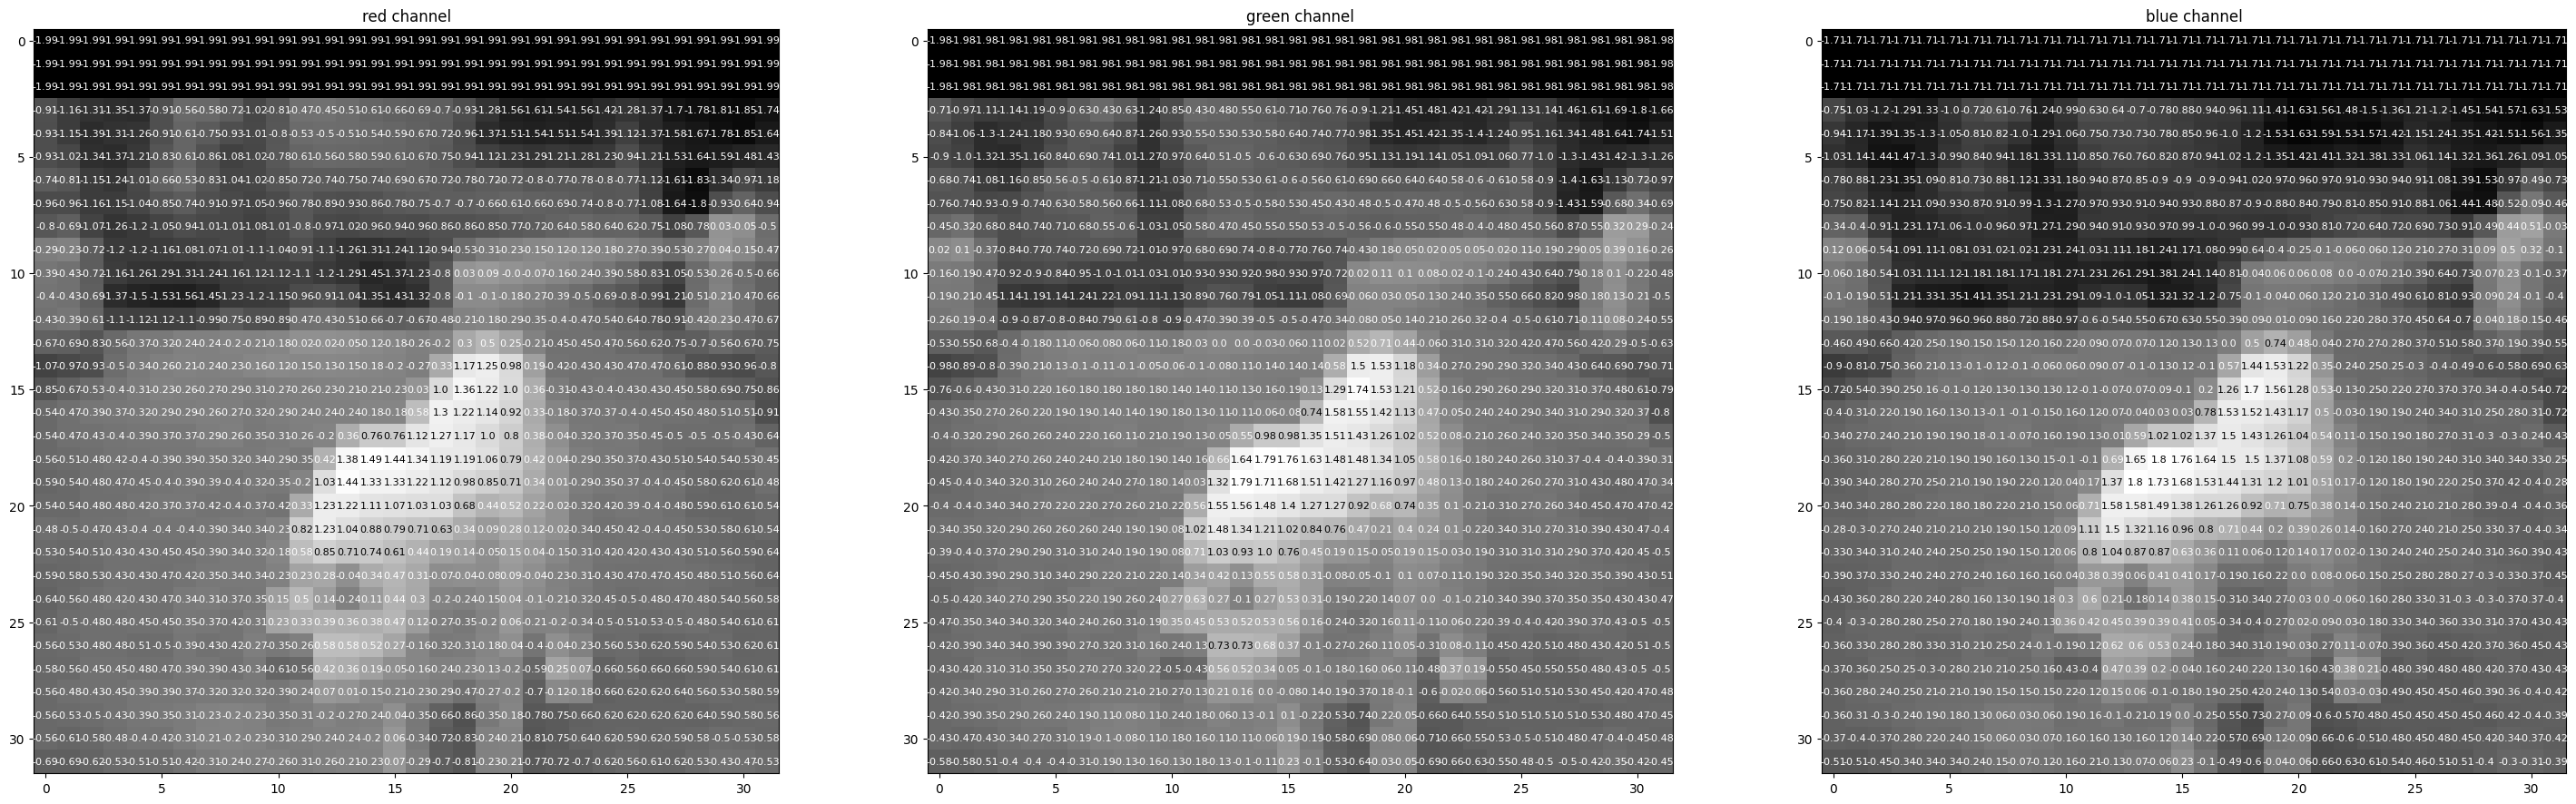

In [9]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    img = img.detach().cpu().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## **TODO**: Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)
---
Build up your own Convolutional Neural Network using Pytorch API:
- nn.Conv2d(): for convolution
- nn.MaxPool2d(): for maxpooling (spatial resolution reduction)
- nn.Linear(): for last 1 or 2 layers of fully connected layer before the output layer.
- nn.Dropout(): optional, [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) can be used to avoid overfitting.
- F.relu(): Use ReLU as the activation function for all the hidden layers

The following is a skeleton example that's not completely working.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
# create a complete CNN
model = Net()
print(model)
model = model.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)
---
Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

The following is working code, but you can make your own adjustments.

**TODO**: try to compare with ADAM optimizer

In [11]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# TODO, compare with optimizer ADAM

## Train the Network
---
Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

In [12]:
# number of epochs to train the model, you decide the number
n_epochs = 25

valid_loss_min = np.inf # track change in validation loss

train_losses = []
valid_losses = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_trained.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.617913 	Validation Loss: 1.264315
Validation loss decreased (inf --> 1.264315).  Saving model ...
Epoch: 2 	Training Loss: 1.260143 	Validation Loss: 1.028088
Validation loss decreased (1.264315 --> 1.028088).  Saving model ...
Epoch: 3 	Training Loss: 1.102412 	Validation Loss: 0.902380
Validation loss decreased (1.028088 --> 0.902380).  Saving model ...
Epoch: 4 	Training Loss: 0.997043 	Validation Loss: 0.882445
Validation loss decreased (0.902380 --> 0.882445).  Saving model ...
Epoch: 5 	Training Loss: 0.944263 	Validation Loss: 0.842019
Validation loss decreased (0.882445 --> 0.842019).  Saving model ...
Epoch: 6 	Training Loss: 0.885592 	Validation Loss: 0.741252
Validation loss decreased (0.842019 --> 0.741252).  Saving model ...
Epoch: 7 	Training Loss: 0.850728 	Validation Loss: 0.697050
Validation loss decreased (0.741252 --> 0.697050).  Saving model ...
Epoch: 8 	Training Loss: 0.820185 	Validation Loss: 0.683587
Validation loss decreased (0.69705

###  Load the Model with the Lowest Validation Loss
This is the model we will use for testing, which is the model we saved in the last step

In [13]:
model.load_state_dict(torch.load('model_trained.pt'))

<All keys matched successfully>

## Test the Trained Network
---
Test your trained model on previously unseen data! Remember we have downloaded `train_data` and `test_data`. We will use `test_data` through `test_loader`.

A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

In [14]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(data.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.553164

Test Accuracy of airplane: 84% (847/1000)
Test Accuracy of automobile: 90% (907/1000)
Test Accuracy of  bird: 66% (660/1000)
Test Accuracy of   cat: 67% (675/1000)
Test Accuracy of  deer: 79% (795/1000)
Test Accuracy of   dog: 72% (723/1000)
Test Accuracy of  frog: 87% (879/1000)
Test Accuracy of horse: 87% (876/1000)
Test Accuracy of  ship: 89% (894/1000)
Test Accuracy of truck: 84% (842/1000)

Test Accuracy (Overall): 80% (8098/10000)


### Visualize Sample Test Results

The following is working code, but you are encouraged to make your own adjustments and enhance the visualization.

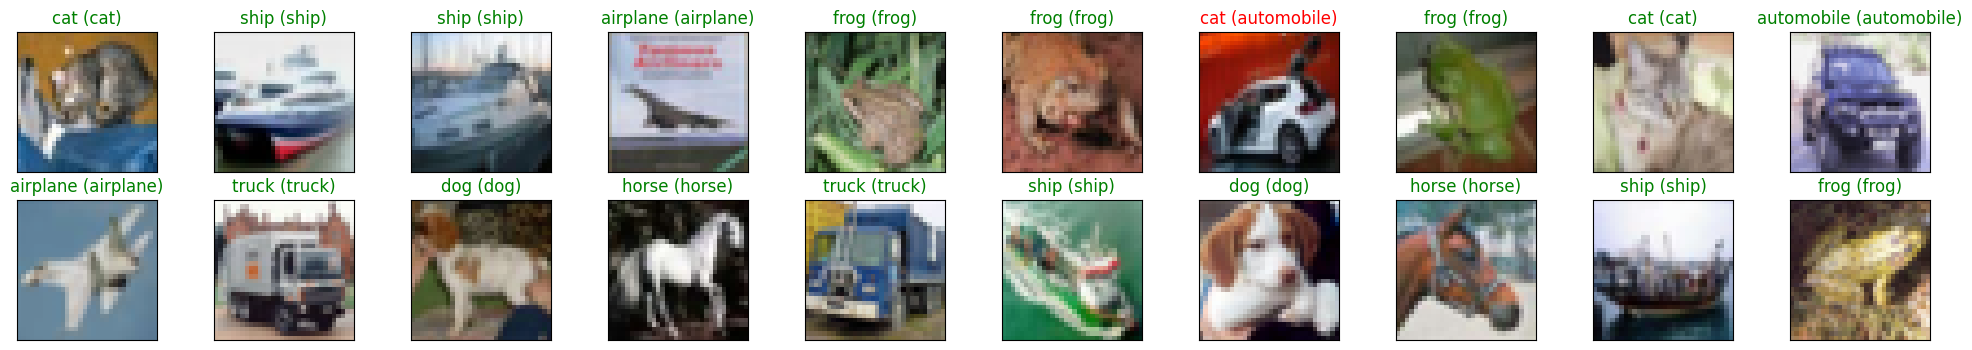

In [15]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)


# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
import os
os.makedirs("outputs", exist_ok=True)
plt.savefig("outputs/sample_predictions_jupyter.png", dpi=200, bbox_inches="tight")

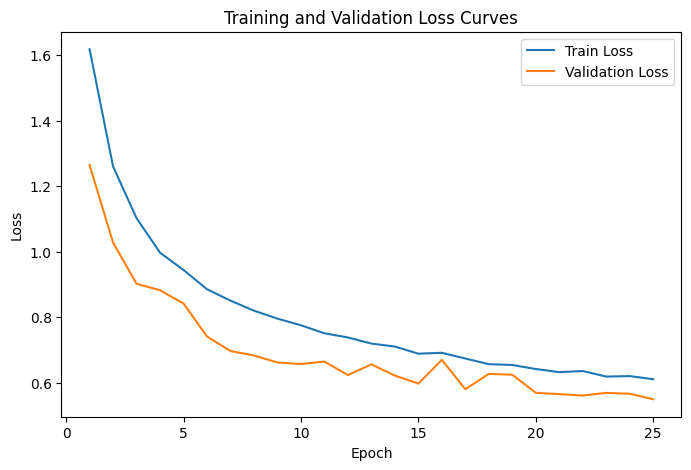

In [16]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(valid_losses)+1), valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

In [17]:
import os
os.makedirs("outputs", exist_ok=True)
plt.savefig("outputs/loss_curves_jupyter.png", dpi=200, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [18]:
import os, json, numpy as np

os.makedirs("outputs", exist_ok=True)

per_class_accuracy = {}
for i in range(len(classes)):
    if class_total[i] > 0:
        per_class_accuracy[classes[i]] = float(100.0 * class_correct[i] / class_total[i])

overall_acc = float(100.0 * np.sum(class_correct) / np.sum(class_total))

metrics = {
    "model_architecture": str(model),
    "loss_function": criterion.__class__.__name__,
    "optimizer": optimizer.__class__.__name__,
    "learning_rate": float(optimizer.param_groups[0]["lr"]),
    "weight_decay": float(optimizer.param_groups[0].get("weight_decay", 0.0)),
    "batch_size": int(batch_size),
    "epochs": int(n_epochs),
    "best_valid_loss": float(np.min(valid_losses)) if len(valid_losses) > 0 else None,
    "final_test_loss": float(test_loss),
    "final_test_accuracy_percent": overall_acc,
    "per_class_accuracy_percent": per_class_accuracy,
    "train_losses": [float(x) for x in train_losses],
    "valid_losses": [float(x) for x in valid_losses],
}

with open("outputs/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved outputs/metrics.json")

Saved outputs/metrics.json


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [26]:
ckpt_path = "model_trained.pt"
if not os.path.exists(ckpt_path):
    ckpt_path = "outputs/model_trained.pt"
ckpt_path
model = Net().to(device)
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)
model.eval()
print("Loaded:", ckpt_path)

Loaded: model_trained.pt


In [27]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_data = datasets.CIFAR10('data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)

In [28]:
mean_t = torch.tensor(mean).view(3,1,1)
std_t = torch.tensor(std).view(3,1,1)

def denorm_img(x):
    y = x.cpu() * std_t + mean_t
    y = torch.clamp(y, 0.0, 1.0)
    return y

def show_img(ax, x, title):
    y = denorm_img(x).numpy().transpose(1,2,0)
    ax.imshow(y)
    ax.set_title(title)
    ax.axis("off")

Selecting 3 images


In [29]:
selected = []
seen = set()

for data, target in test_loader:
    for i in range(data.size(0)):
        y = int(target[i].item())
        if y not in seen:
            selected.append((data[i].cpu(), y))
            seen.add(y)
            if len(selected) == 3:
                break
    if len(selected) == 3:
        break

[(classes[y], y) for _, y in selected]

[('cat', 3), ('ship', 8), ('airplane', 0)]

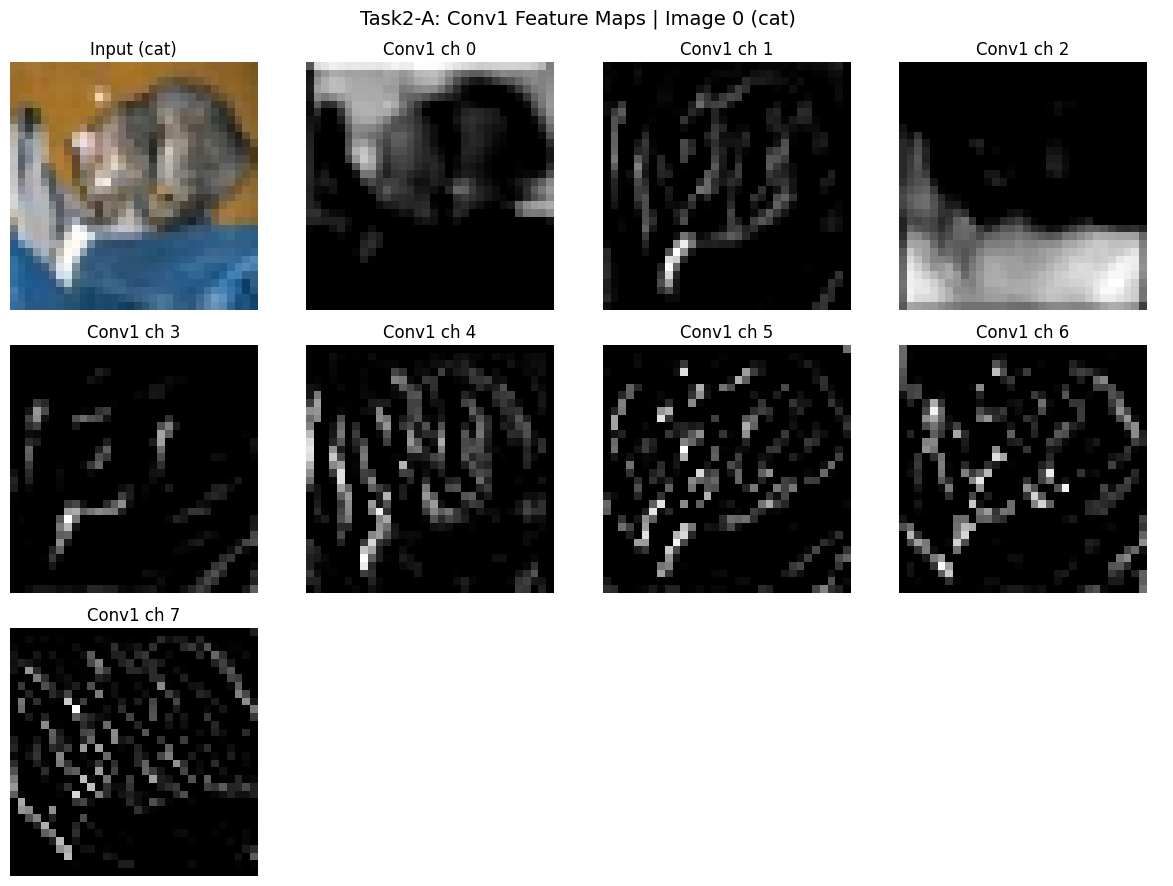

Saved outputs/task2A_conv1_featuremaps_img0.png


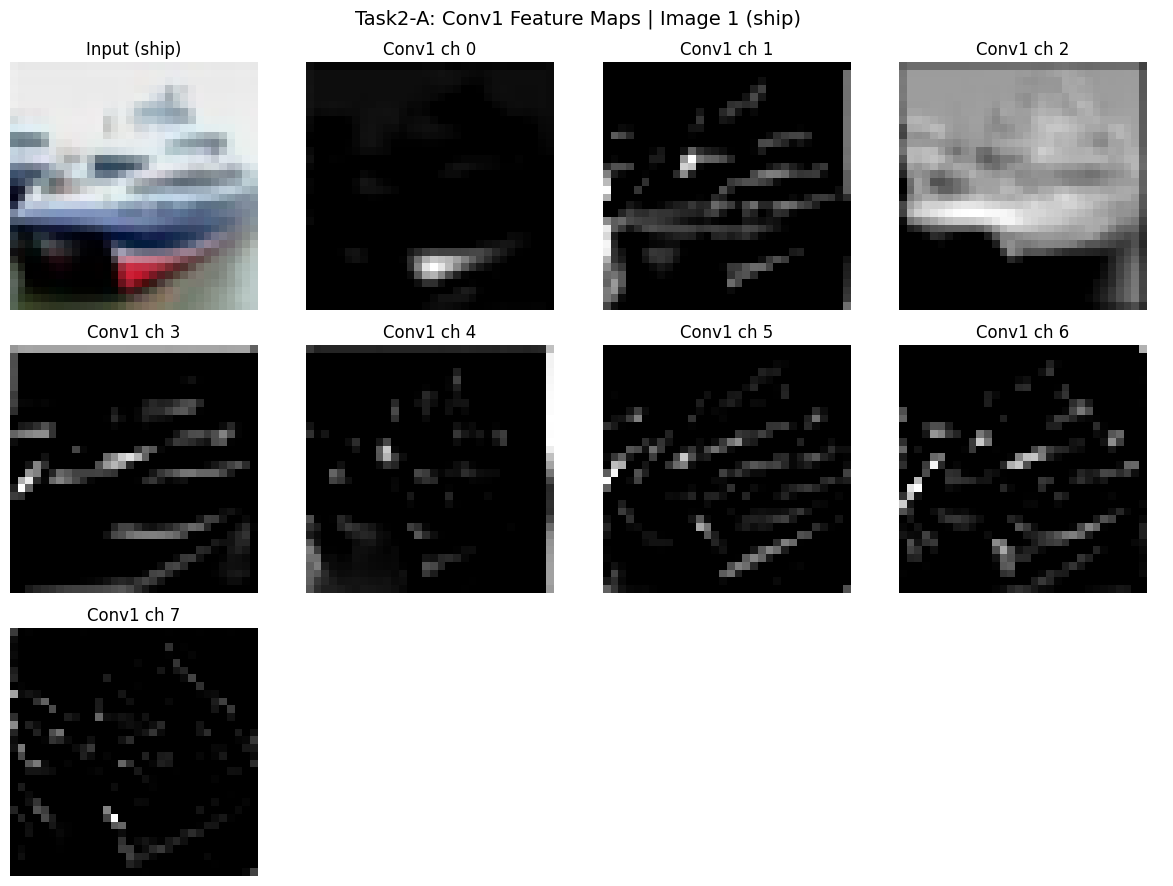

Saved outputs/task2A_conv1_featuremaps_img1.png


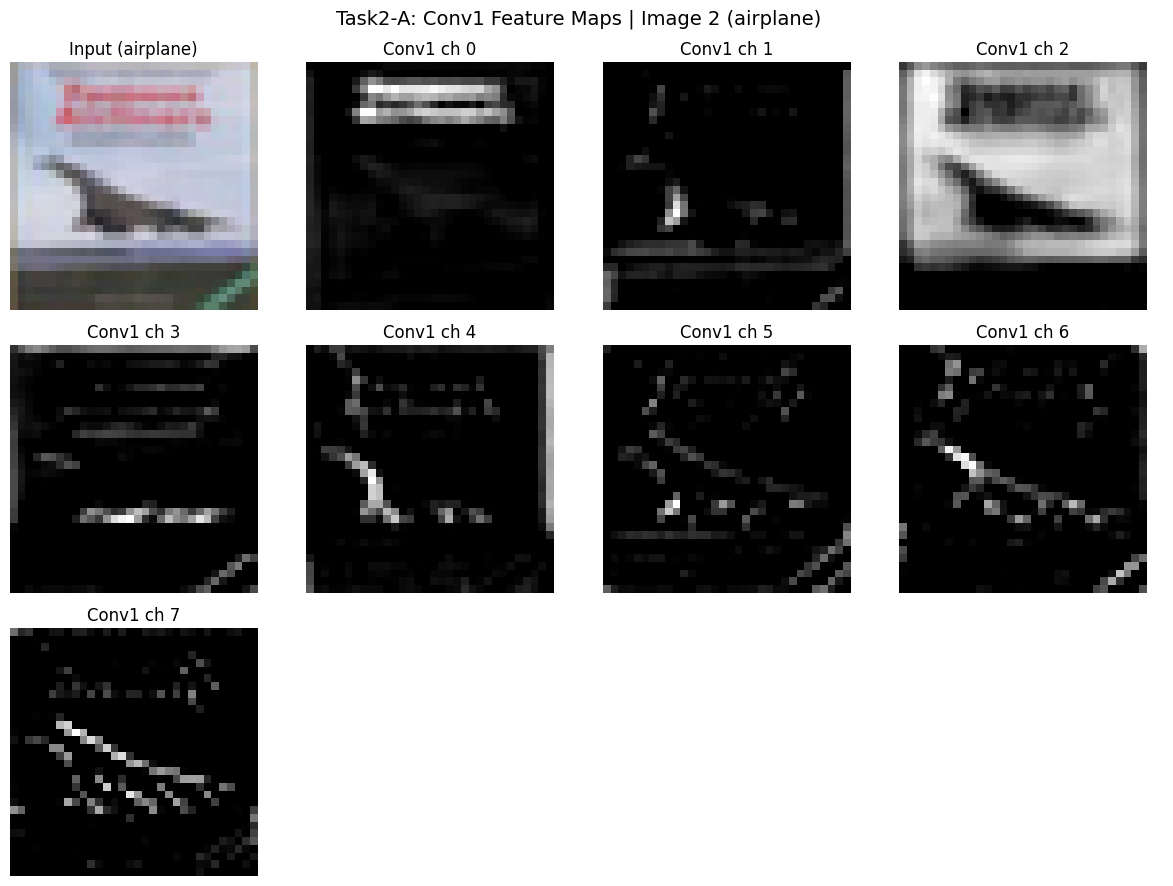

Saved outputs/task2A_conv1_featuremaps_img2.png


In [30]:
os.makedirs("outputs", exist_ok=True)

def plot_conv1_featuremaps(img, y, img_idx, channels_to_show=8):
    x = img.unsqueeze(0).to(device)
    with torch.no_grad():
        fm = torch.relu(model.conv1(x)).squeeze(0).cpu()

    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.flatten()

    show_img(axes[0], img, f"Input ({classes[y]})")

    for k in range(channels_to_show):
        ax = axes[k+1]
        ax.imshow(fm[k].numpy(), cmap="gray")
        ax.set_title(f"Conv1 ch {k}")
        ax.axis("off")

    for k in range(channels_to_show+1, 12):
        axes[k].axis("off")

    fig.suptitle(f"Task2-A: Conv1 Feature Maps | Image {img_idx} ({classes[y]})", fontsize=14)
    plt.tight_layout()
    out_path = f"outputs/task2A_conv1_featuremaps_img{img_idx}.png"
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved", out_path)

for i, (img, y) in enumerate(selected):
    plot_conv1_featuremaps(img, y, i, channels_to_show=8)

In [33]:
layer_name = "conv2"
activation_mode = "mean"

C = model.conv2.out_channels
sum_per_filter = torch.zeros(C)
count = 0

for data, target in test_loader:
    b = data.size(0)
    data = data.to(device)

    with torch.no_grad():
        x1 = model.pool(torch.relu(model.conv1(data)))
        fm = torch.relu(model.conv2(x1))

    if activation_mode == "mean":
        s = fm.mean(dim=(2,3)).detach().cpu()
    else:
        s = fm.amax(dim=(2,3)).detach().cpu()

    sum_per_filter += s.sum(dim=0)
    count += b

avg_per_filter = sum_per_filter / count
top = torch.topk(avg_per_filter, k=min(20, C)).indices.tolist()

keep = set([10, 20])
new0 = None
for f in top:
    if f not in keep:
        new0 = f
        break

new0, top[:10]

(13, [13, 58, 62, 59, 39, 10, 8, 32, 50, 57])

Maximally activating images (top-5) for 3 filters

In [34]:
layer_name = "conv2"
filter_ids = [13, 10, 20]
activation_mode = "mean"

scores = [ [] for _ in filter_ids ]
labels_all = []
idx_all = []

base = 0
for data, target in test_loader:
    b = data.size(0)
    data = data.to(device)

    with torch.no_grad():
        x1 = model.pool(torch.relu(model.conv1(data)))
        fm = torch.relu(model.conv2(x1))

    for j, f in enumerate(filter_ids):
        if activation_mode == "mean":
            s = fm[:, f, :, :].mean(dim=(1,2)).detach().cpu()
        else:
            s = fm[:, f, :, :].amax(dim=(1,2)).detach().cpu()
        scores[j].append(s)

    labels_all.append(target.cpu())
    idx_all.append(torch.arange(base, base + b))
    base += b

labels_all = torch.cat(labels_all)
idx_all = torch.cat(idx_all)
scores = [ torch.cat(scores[j]) for j in range(len(filter_ids)) ]

[(layer_name, filter_ids, activation_mode), scores[0].shape, labels_all.shape, idx_all.shape]

[('conv2', [13, 10, 20], 'mean'),
 torch.Size([10000]),
 torch.Size([10000]),
 torch.Size([10000])]

visualizing top 5 images per filter

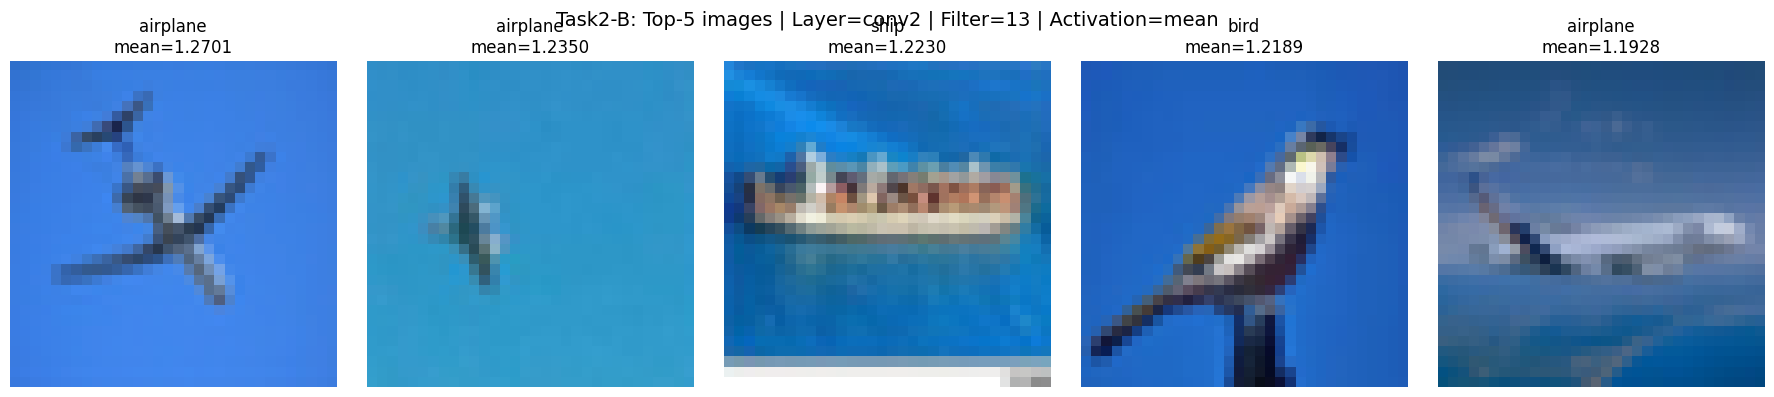

Saved outputs/task2B_top5_conv2_filter13.png
Top indices: [2968, 3278, 9784, 391, 1712]


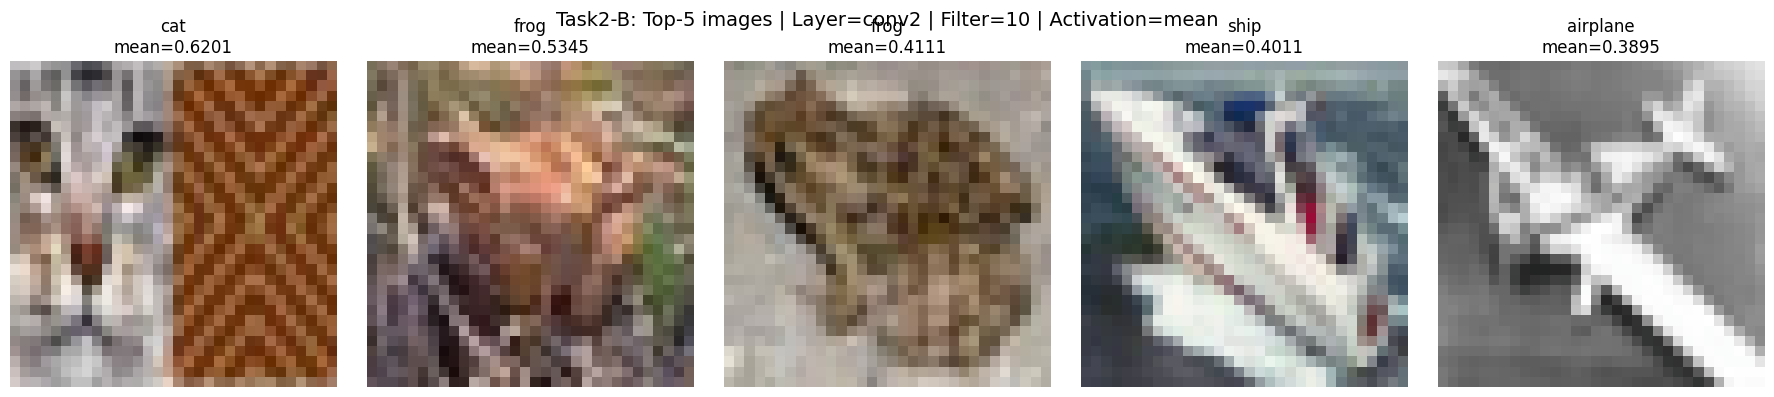

Saved outputs/task2B_top5_conv2_filter10.png
Top indices: [8169, 4772, 4671, 2578, 2257]


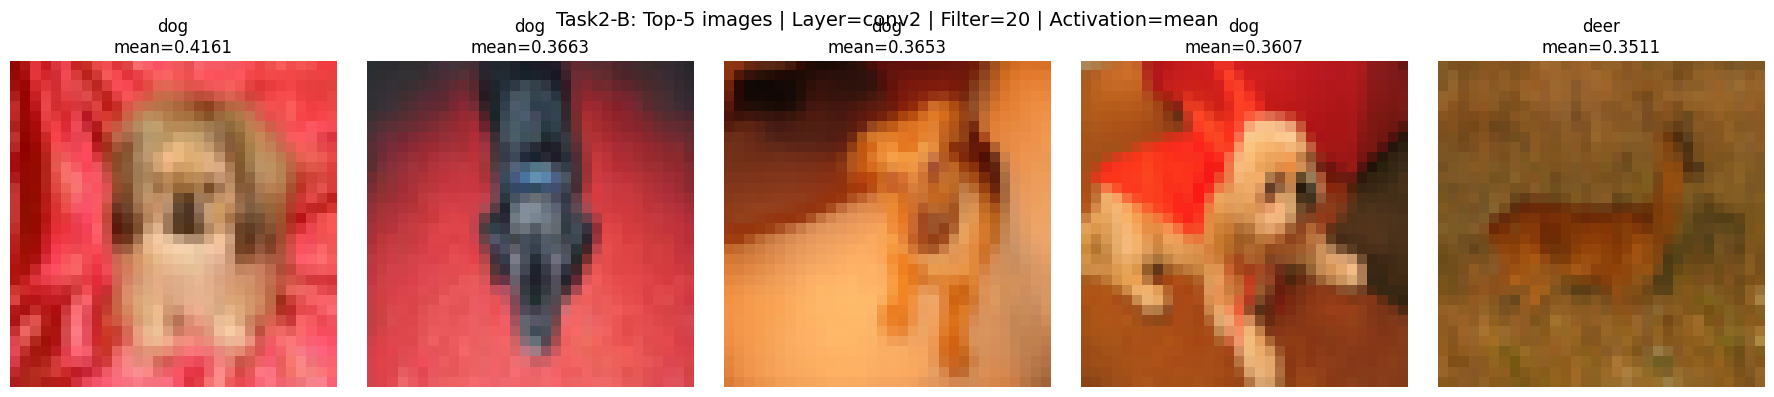

Saved outputs/task2B_top5_conv2_filter20.png
Top indices: [3221, 5774, 6035, 7529, 6461]


In [35]:
def plot_top5_for_filter(f, svec, labels_vec, idx_vec, fig_id):
    top = torch.topk(svec, k=5)
    top_scores = top.values.numpy()
    top_indices = idx_vec[top.indices].numpy()

    fig, axes = plt.subplots(1, 5, figsize=(18, 4))
    for k in range(5):
        idx = int(top_indices[k])
        img, y = test_data[idx]
        show_img(axes[k], img, f"{classes[y]}\n{activation_mode}={top_scores[k]:.4f}")

    fig.suptitle(f"Task2-B: Top-5 images | Layer={layer_name} | Filter={f} | Activation={activation_mode}", fontsize=14)
    plt.tight_layout()
    out_path = f"outputs/task2B_top5_{layer_name}_filter{f}.png"
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved", out_path)
    print("Top indices:", top_indices.tolist())

for j, f in enumerate(filter_ids):
    plot_top5_for_filter(f, scores[j], labels_all, idx_all, j)